In [1]:
import sys
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk"))

# ROOT!
import os, sys
os.environ["ROOTSYS"] = "/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/software/ROOT/ROOT_6.26.14/install"
sys.path.append(os.path.join(os.environ["ROOTSYS"], "lib"))

import hipy.hipy.pltext  as pltext
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import pandas            as pd

from nHits_trigger.src.read_data          import nHits, read_mpmt_offsets
from WCTE_BRB_Data_Analysis.wcte.brbtools import sort_run_files, get_part_files

from tqdm import tqdm

pltext.style()

# Read Data And Correct TOF

In [37]:
bkg__run = 1766

bkg__run_files  = sort_run_files(f"/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/raw_data/production_v0/{bkg__run}/WCTE_offline_R{bkg__run}S*P*.root")
bkg__part_files = get_part_files(bkg__run_files)

# Run Variables
bkg__run_corrected_times           = []
bkg__run_hit_charges               = []
bkg__run_hit_card_ids              = []
bkg__run_hit_channel_ids           = []
bkg__run_hit_slot_ids              = []
bkg__run_hit_position_ids          = []
bkg__run_hit_pmt_has_time_constant = []

ev_offset = 0
for part in bkg__part_files[:1]:
    print(f"Processing part WCTE_offline_R{bkg__run}S0P{part}")
    bkg__tree = uproot.open(bkg__run_files[part] + ":WCTEReadoutWindows")
    
    # Read the variables
    bkg__file_hit_card_ids              = ak.values_astype(bkg__tree["hit_mpmt_card_ids"]        .array(), np.int16)
    bkg__file_hit_channel_ids           = ak.values_astype(bkg__tree["hit_pmt_channel_ids"]      .array(), np.int8)
    bkg__file_hit_times                 = ak.values_astype(bkg__tree["hit_pmt_times"]            .array(), np.float64)
    bkg__file_hit_times_calib           = ak.values_astype(bkg__tree["hit_pmt_calibrated_times"] .array(), np.float64)
    bkg__file_hit_charges               = ak.values_astype(bkg__tree["hit_pmt_charges"]          .array(), np.float64)
    bkg__file_hit_slot_ids              = ak.values_astype(bkg__tree["hit_mpmt_slot_ids"]        .array(), np.int16)
    bkg__file_hit_position_ids          = ak.values_astype(bkg__tree["hit_pmt_position_ids"]     .array(), np.int16)
    bkg__file_hit_pmt_has_time_constant = ak.values_astype(bkg__tree["hit_pmt_has_time_constant"].array(), np.bool)

    mpmt_map = read_mpmt_offsets("/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/mpmt_tof_map/mpmt_tof_pos1525.json")

    max_slot = 106
    max_pos  = 19

    # Build lookup
    lookup = np.zeros((max_slot, max_pos))
    for (card, chan), shift in mpmt_map.items():
        lookup[card, chan] = shift

    # Hit Times Correction
    bkg__flat_slot_ids     = ak.ravel(bkg__file_hit_slot_ids)
    bkg__flat_pos_ids      = ak.ravel(bkg__file_hit_position_ids)
    bkg__flat_corrections  = lookup[bkg__flat_slot_ids, bkg__flat_pos_ids]
    bkg__corrections       = ak.unflatten(bkg__flat_corrections, ak.num(bkg__file_hit_card_ids))

    bkg__term1           = bkg__file_hit_times_calib
    bkg__corrected_times = bkg__term1 - bkg__corrections 

    # Filter Out Main Things
    mask = (bkg__file_hit_charges < 1e4) & (bkg__file_hit_card_ids < 120) & (bkg__file_hit_pmt_has_time_constant != 0)
    bkg__corrected_times                = bkg__corrected_times                [mask]
    bkg__file_hit_charges               = bkg__file_hit_charges               [mask]
    bkg__file_hit_card_ids              = bkg__file_hit_card_ids              [mask]
    bkg__file_hit_channel_ids           = bkg__file_hit_channel_ids           [mask]
    bkg__file_hit_slot_ids              = bkg__file_hit_slot_ids              [mask]
    bkg__file_hit_position_ids          = bkg__file_hit_position_ids          [mask]
    bkg__file_hit_pmt_has_time_constant = bkg__file_hit_pmt_has_time_constant [mask]

    # SUPER IMPORTANT! We want the hit time time-ordered, and we want to order the other variables the same way so later we can filter out by index in the array
    order = ak.argsort(bkg__corrected_times)
    
    bkg__run_corrected_times          .append(bkg__corrected_times               [order])
    bkg__run_hit_charges              .append(bkg__file_hit_charges              [order])
    bkg__run_hit_card_ids             .append(bkg__file_hit_card_ids             [order])    
    bkg__run_hit_channel_ids          .append(bkg__file_hit_channel_ids          [order]) 
    bkg__run_hit_slot_ids             .append(bkg__file_hit_slot_ids             [order])    
    bkg__run_hit_position_ids         .append(bkg__file_hit_position_ids         [order])
    bkg__run_hit_pmt_has_time_constant.append(bkg__file_hit_pmt_has_time_constant[order])

bkg__run_corrected_times           = ak.concatenate(bkg__run_corrected_times          )
bkg__run_hit_charges               = ak.concatenate(bkg__run_hit_charges              )
bkg__run_hit_card_ids              = ak.concatenate(bkg__run_hit_card_ids             )
bkg__run_hit_channel_ids           = ak.concatenate(bkg__run_hit_channel_ids          )
bkg__run_hit_slot_ids              = ak.concatenate(bkg__run_hit_slot_ids             )
bkg__run_hit_position_ids          = ak.concatenate(bkg__run_hit_position_ids         )
bkg__run_hit_pmt_has_time_constant = ak.concatenate(bkg__run_hit_pmt_has_time_constant)

Processing part WCTE_offline_R1766S0P0


In [2]:
nicf_run = 1769

nicf_run_files  = sort_run_files(f"/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/raw_data/production_v0/{nicf_run}/WCTE_offline_R{nicf_run}S*P*.root")
nicf_part_files = get_part_files(nicf_run_files)

# Run Variables
nicf_run_corrected_times           = []
nicf_run_hit_charges               = []
nicf_run_hit_card_ids              = []
nicf_run_hit_channel_ids           = []
nicf_run_hit_slot_ids              = []
nicf_run_hit_position_ids          = []
nicf_run_hit_pmt_has_time_constant = []

ev_offset = 0
for part in nicf_part_files[:1]:
    print(f"Processing part WCTE_offline_R{nicf_run}S0P{part}")
    nicf_tree = uproot.open(nicf_run_files[part] + ":WCTEReadoutWindows")
    
    # Read the variables
    nicf_file_hit_card_ids              = ak.values_astype(nicf_tree["hit_mpmt_card_ids"]        .array(), np.int16)
    nicf_file_hit_channel_ids           = ak.values_astype(nicf_tree["hit_pmt_channel_ids"]      .array(), np.int8)
    nicf_file_hit_times                 = ak.values_astype(nicf_tree["hit_pmt_times"]            .array(), np.float64)
    nicf_file_hit_times_calib           = ak.values_astype(nicf_tree["hit_pmt_calibrated_times"] .array(), np.float64)
    nicf_file_hit_charges               = ak.values_astype(nicf_tree["hit_pmt_charges"]          .array(), np.float64)
    nicf_file_hit_slot_ids              = ak.values_astype(nicf_tree["hit_mpmt_slot_ids"]        .array(), np.int16)
    nicf_file_hit_position_ids          = ak.values_astype(nicf_tree["hit_pmt_position_ids"]     .array(), np.int16)
    nicf_file_hit_pmt_has_time_constant = ak.values_astype(nicf_tree["hit_pmt_has_time_constant"].array(), np.bool)

    mpmt_map = read_mpmt_offsets("/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/mpmt_tof_map/mpmt_tof_pos1525.json")

    max_slot = 106
    max_pos  = 19

    # Build lookup
    lookup = np.zeros((max_slot, max_pos))
    for (card, chan), shift in mpmt_map.items():
        lookup[card, chan] = shift

    # Hit Times Correction
    nicf_flat_slot_ids     = ak.ravel(nicf_file_hit_slot_ids)
    nicf_flat_pos_ids      = ak.ravel(nicf_file_hit_position_ids)
    nicf_flat_corrections  = lookup[nicf_flat_slot_ids, nicf_flat_pos_ids]
    nicf_corrections       = ak.unflatten(nicf_flat_corrections, ak.num(nicf_file_hit_card_ids))

    nicf_term1           = nicf_file_hit_times_calib
    nicf_corrected_times = nicf_term1 - nicf_corrections 

    # Filter Out Main Things
    mask = (nicf_file_hit_charges < 1e4) & (nicf_file_hit_card_ids < 120) & (nicf_file_hit_pmt_has_time_constant != 0)
    nicf_corrected_times                = nicf_corrected_times                [mask]
    nicf_file_hit_charges               = nicf_file_hit_charges               [mask]
    nicf_file_hit_card_ids              = nicf_file_hit_card_ids              [mask]
    nicf_file_hit_channel_ids           = nicf_file_hit_channel_ids           [mask]
    nicf_file_hit_slot_ids              = nicf_file_hit_slot_ids              [mask]
    nicf_file_hit_position_ids          = nicf_file_hit_position_ids          [mask]
    nicf_file_hit_pmt_has_time_constant = nicf_file_hit_pmt_has_time_constant [mask]

    # SUPER IMPORTANT! We want the hit time time-ordered, and we want to order the other variables the same way so later we can filter out by index in the array
    order = ak.argsort(nicf_corrected_times)
    
    nicf_run_corrected_times          .append(nicf_corrected_times               [order])
    nicf_run_hit_charges              .append(nicf_file_hit_charges              [order])
    nicf_run_hit_card_ids             .append(nicf_file_hit_card_ids             [order])    
    nicf_run_hit_channel_ids          .append(nicf_file_hit_channel_ids          [order]) 
    nicf_run_hit_slot_ids             .append(nicf_file_hit_slot_ids             [order])    
    nicf_run_hit_position_ids         .append(nicf_file_hit_position_ids         [order])
    nicf_run_hit_pmt_has_time_constant.append(nicf_file_hit_pmt_has_time_constant[order])

nicf_run_corrected_times           = ak.concatenate(nicf_run_corrected_times          )
nicf_run_hit_charges               = ak.concatenate(nicf_run_hit_charges              )
nicf_run_hit_card_ids              = ak.concatenate(nicf_run_hit_card_ids             )
nicf_run_hit_channel_ids           = ak.concatenate(nicf_run_hit_channel_ids          )
nicf_run_hit_slot_ids              = ak.concatenate(nicf_run_hit_slot_ids             )
nicf_run_hit_position_ids          = ak.concatenate(nicf_run_hit_position_ids         )
nicf_run_hit_pmt_has_time_constant = ak.concatenate(nicf_run_hit_pmt_has_time_constant)

Processing part WCTE_offline_R1769S0P0


# nHits To Find Spills and AfterPulsing

In [8]:
# bkg__triggered_spill_hits_index, bkg__triggered_spill_hit_times = nHits(mode="multiple_events", hit_times=bkg__run_corrected_times, w=5000, thresh_min=300, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)
nicf_triggered_spill_hits_index, nicf_triggered_spill_hit_times = nHits(mode="multiple_events", hit_times=nicf_run_corrected_times, w=5000, thresh_min=300, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)

  0%|          | 0/6760 [00:00<?, ?it/s]

100%|██████████| 6760/6760 [00:03<00:00, 1759.93it/s]


### Remove Spills from data

In [9]:
def remove_spill(trigger_indices, run_times):
    corrected_run_times = []

    for i in tqdm(range(len(run_times))):
        if i in trigger_indices:
            #Event with spill → remove selected indices
            if len(trigger_indices[i]) > 0:
                data = run_times[i]
                trigger_indices_event = np.concatenate(trigger_indices[i])
                all_indices           = np.arange(len(data))
                valid_indices         = np.setdiff1d(all_indices, trigger_indices_event)
                corrected_run_times.append(data[valid_indices])
            
            else:
                continue
        else:
            # Event without spill → leave as it is
            corrected_run_times.append(run_times[i])

    return ak.Array(corrected_run_times)

In [10]:
# Hit Time
# bkg__noSpill_times  = remove_spill(bkg__triggered_spill_hits_index, bkg__run_corrected_times)
nicf_noSpill_times  = remove_spill(nicf_triggered_spill_hits_index, nicf_run_corrected_times)

# Hit Charge
# bkg__noSpill_charge = remove_spill(bkg__triggered_spill_hits_index, bkg__run_hit_charges)
# nicf_noSpill_charge = remove_spill(nicf_triggered_spill_hits_index, nicf_run_hit_charges)

# # Slot IDs
# bkg__noSpill_slotIDs = remove_spill(bkg__triggered_spill_hits_index, bkg__run_hit_slot_ids)
# nicf_noSpill_slotIDs = remove_spill(nicf_triggered_spill_hits_index, nicf_run_hit_slot_ids)

# # Positions IDs
# bkg__noSpill_posIDs  = remove_spill(bkg__triggered_spill_hits_index, bkg__run_hit_position_ids)
# nicf_noSpill_posIDs  = remove_spill(nicf_triggered_spill_hits_index, nicf_run_hit_position_ids)

100%|██████████| 6760/6760 [00:01<00:00, 4555.70it/s]


# Explore Data

### Events

In [12]:
nicf_run_hit_charges[0]

<Array [403, 268, 143, 190, 148, ..., 86, 158, 114, 182] type='642 * float64'>

In [3]:
len(nicf_run_corrected_times)

6760

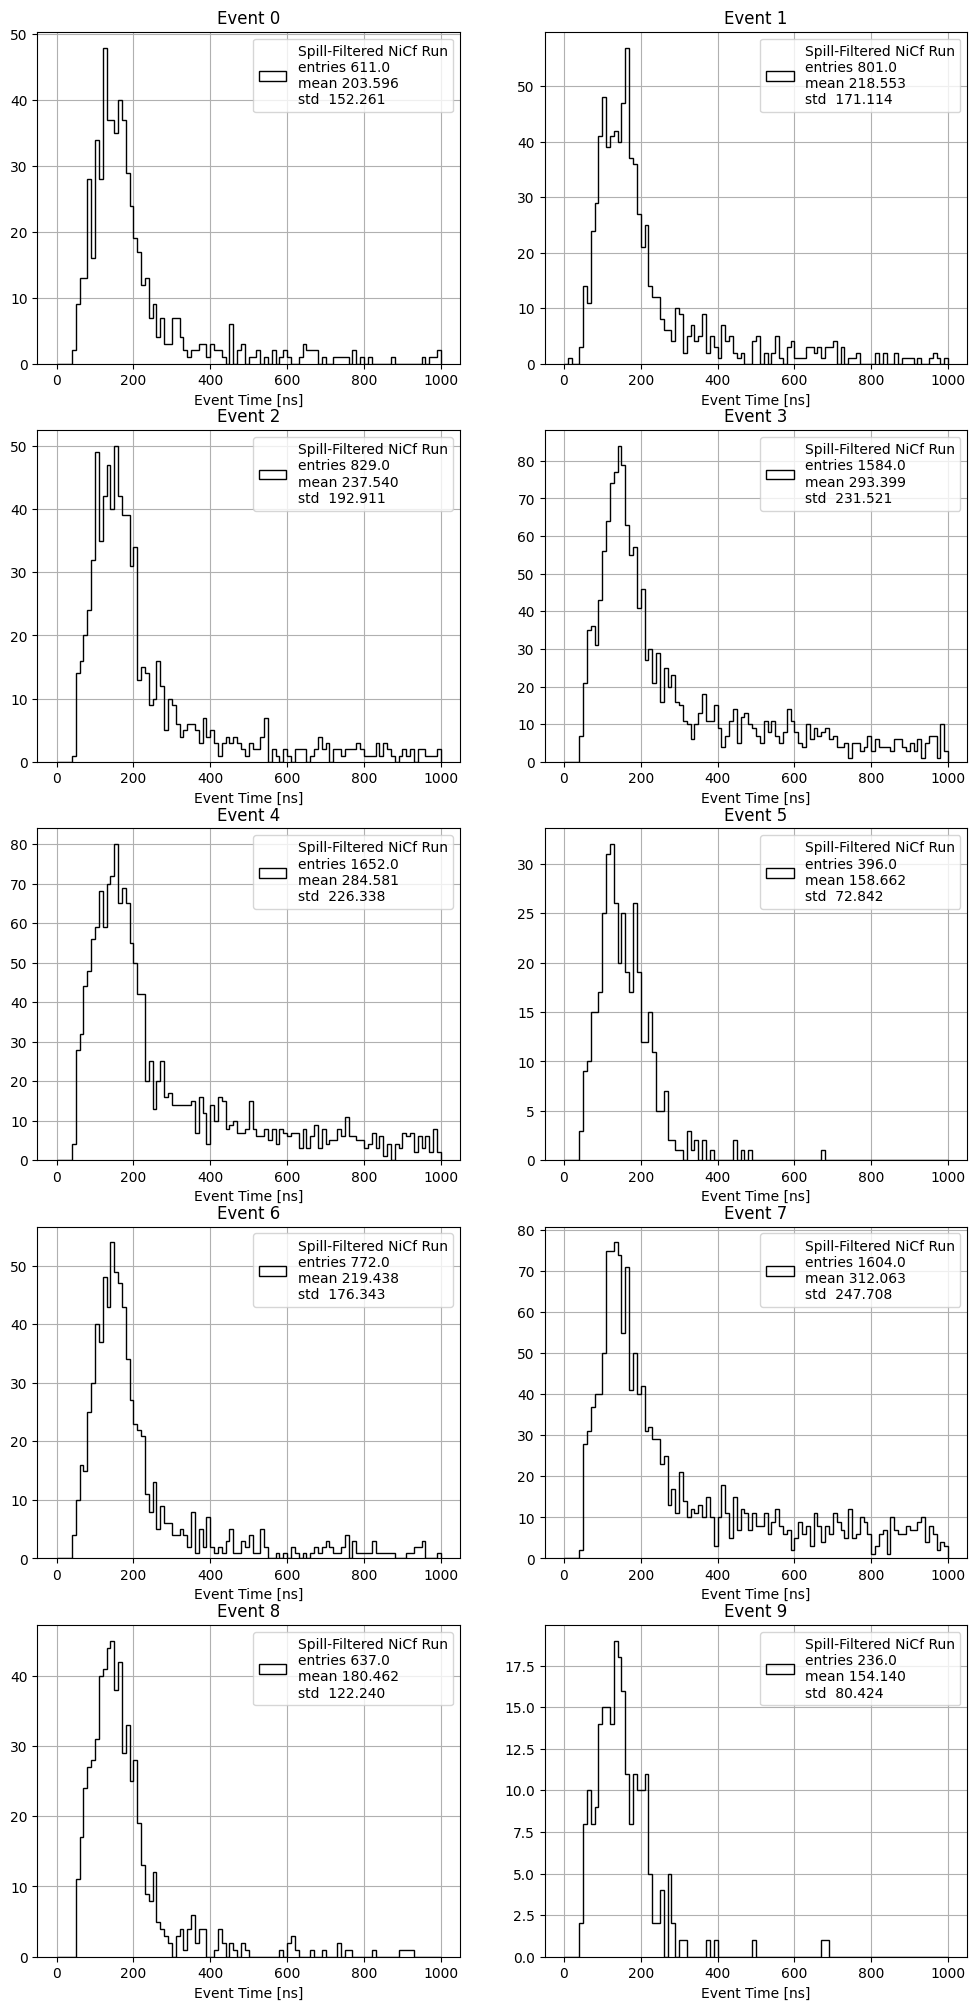

In [14]:
events = [0,1,2,3,4,5,6,7,8,9]
subplot = pltext.canvas(len(events))

for i, ev in enumerate(events):
    
    subplot(i+1)
    # pltext.hist(nicf_corrected_times[ev], 100, range=(0,5e5), xylabels="Event Time [ns]", label="Non-Spill-Filtered NiCf Run");
    pltext.hist(nicf_run_hit_charges[ev],   100, range=(0,1e3), xylabels="Event Time [ns]", label="Spill-Filtered NiCf Run");
    # plt.hlines(40, 0, 5e5);

    plt.title(f"Event {ev}");

### PMT Hits

In [8]:
hit_pmts = ak.flatten(nicf_run_hit_slot_ids*19 + nicf_run_hit_position_ids)
hit_pmts_noSpill = ak.flatten(nicf_noSpill_slotIDs*19 + nicf_noSpill_posIDs)

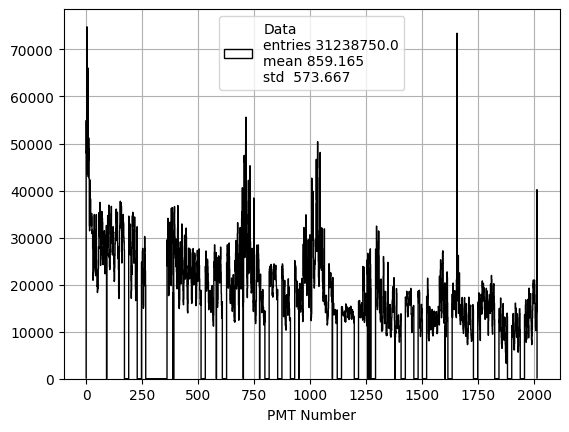

In [9]:
pltext.hist(hit_pmts, 2013, xylabels="PMT Number", label="Data");

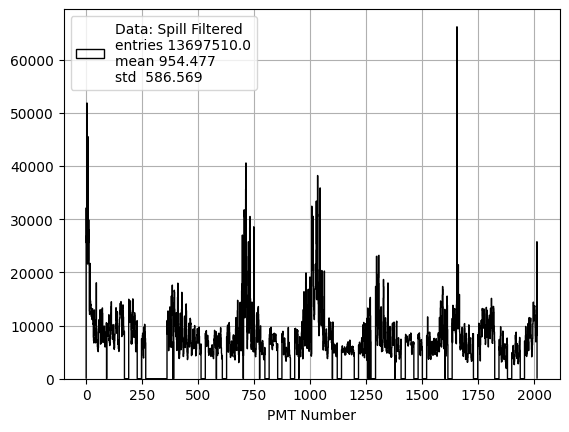

In [10]:
pltext.hist(hit_pmts_noSpill, 2013, xylabels="PMT Number", label="Data: Spill Filtered ");

# nHits Algorithm

In [11]:
def nHits(mode, hit_times, w, thresh_min, thresh_max, pre_window, post_window, jump, event=0, progress_bar=True):
    def process_event(ht, w, thresh_min, thresh_max, pre_window, post_window, jump):
        if len(ht) == 0:
            return [], []

        triggered_hits_index = []
        triggered_hits_time = []

        ends   = ht + w
        right  = np.searchsorted(ht, ends, side="left")
        left   = np.arange(len(ht))
        counts = right - left

        # Posibles inicios de cluster
        trigger_indices = np.where((counts >= thresh_min) & (counts < thresh_max))[0]
        if len(trigger_indices) == 0:
            return [], []

        used_hits = set()
        last_trigger_time = -np.inf

        for idx in trigger_indices:
            if ht[idx] in used_hits:
                continue  # este hit ya pertenece a un cluster previo

            # Define los límites de ventana para este posible cluster
            t_min = ht[idx]
            t_max = ht[idx] + w

            indices_in_window = np.where((ht >= t_min) & (ht <= t_max))[0]
            if len(indices_in_window) < thresh_min:
                continue  # no alcanza el umbral inferior

            # Limita tamaño máximo de cluster
            if len(indices_in_window) > thresh_max:
                indices_in_window = indices_in_window[:thresh_max]

            hit_times_in_window = ht[indices_in_window]
            first_hit_time = hit_times_in_window[0]

            # Evita solapamientos temporales (dead time)
            if first_hit_time < last_trigger_time + jump:
                continue

            # Si algún hit de este cluster ya fue usado, se descarta
            if any(ht[i] in used_hits for i in indices_in_window):
                continue

            # Expande si hay pre/post window
            t_min_expanded = hit_times_in_window[0] - pre_window
            t_max_expanded = hit_times_in_window[-1] + post_window
            indices_final = np.where((ht >= t_min_expanded) & (ht <= t_max_expanded))[0]
            hit_times_final = ht[indices_final]

            # Guarda el cluster
            triggered_hits_index.append(indices_final)
            triggered_hits_time.append(hit_times_final)
            last_trigger_time = hit_times_final[-1]

            # Marca hits usados
            used_hits.update(ht[indices_final])

        return triggered_hits_index, triggered_hits_time

    # --- SINGLE EVENT ---
    if mode == "single_event":
        ht = ak.to_numpy(hit_times[event])
        idxs, times = process_event(ht, w, thresh_min, thresh_max, pre_window, post_window, jump)
        return {event: idxs}, {event: times}

    # --- MULTIPLE EVENTS ---
    elif mode == "multiple_events":
        nevents = len(hit_times)
        triggered_hits_index = {}
        triggered_hits_time  = {}

        for event in tqdm(range(nevents), total=nevents, leave=progress_bar):
            ht = ak.to_numpy(hit_times[event])
            if len(ht) == 0:
                triggered_hits_index[event] = []
                triggered_hits_time[event]  = []
                continue

            idxs, times = process_event(ht, w, thresh_min, thresh_max, pre_window, post_window, jump)
            triggered_hits_index[event] = idxs
            triggered_hits_time[event]  = times
            if len(idxs) > 0:
                triggered_hits_index[event] = idxs
                triggered_hits_time[event]  = times

        return triggered_hits_index, triggered_hits_time

    else:
        print("enter a valid mode name")
        return {}, {}


# 50 ns Clusterization v2

In [12]:
thresh_inf     = 2   # hits
thresh_sup     = 140 # hits
sliding_window = 20  # ns
dead_time      = 20  # ns

# nHits
bkg__triggered_signal_hits_index, bkg__triggered_signal_hit_times = nHits(mode="multiple_events", hit_times=bkg__noSpill_times, w=sliding_window, thresh_min=thresh_inf, thresh_max=thresh_sup, pre_window=0, post_window=0, jump=dead_time)
nicf_triggered_signal_hits_index, nicf_triggered_signal_hit_times = nHits(mode="multiple_events", hit_times=nicf_noSpill_times, w=sliding_window, thresh_min=thresh_inf, thresh_max=thresh_sup, pre_window=0, post_window=0, jump=dead_time)

# tRMS
bkg__rms_50ns  = []
bkg__50ns_size = []
for k,v in tqdm(bkg__triggered_signal_hit_times.items(), total=len(bkg__triggered_signal_hit_times.items()), leave=False):
        for i in bkg__triggered_signal_hit_times.get(k):
            bkg__rms_50ns.append(np.std(i, ddof=0))
            bkg__50ns_size.append(len(i))

nicf_rms_50ns  = []
nicf_50ns_size = []
# nicf_50ns_charge = []

for k,v in tqdm(nicf_triggered_signal_hit_times.items(), total=len(nicf_triggered_signal_hit_times.items()), leave=False):
        for i in nicf_triggered_signal_hit_times.get(k):
            nicf_rms_50ns.append(np.std(i, ddof=0))
            nicf_50ns_size.append(len(i))
            # nicf_50ns_mean_charge.append(np.mean())

 25%|██▌       | 11867/47109 [00:02<00:07, 4438.69it/s]

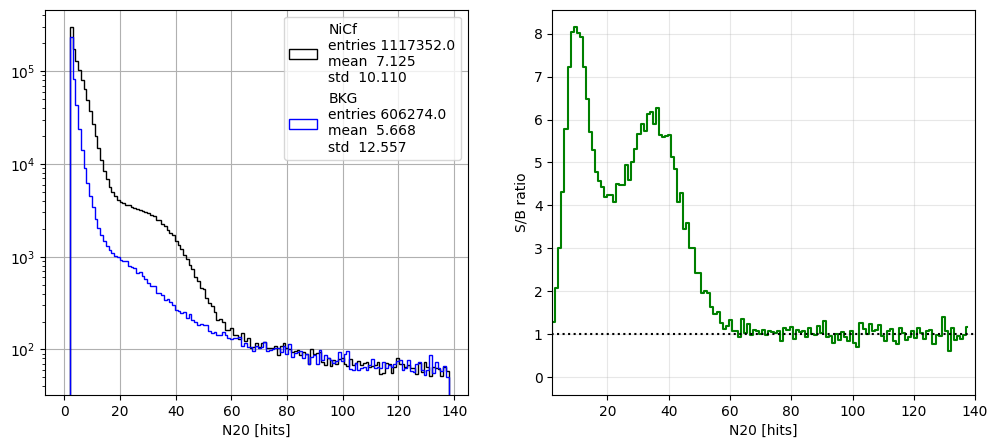

In [35]:
v_sig, b_sig = np.histogram(nicf_50ns_size, 136, range=(thresh_inf, 138));
v_bkg, b_bkg = np.histogram(bkg__50ns_size, 136, range=(thresh_inf, 138));

N_nicf = v_sig.sum()
N_bkg  = v_bkg.sum()
bins = np.arange(2, 139)

# --- Factor de escala global (regla de tres) ---
scale_factor = len(nicf_run_corrected_times)/len(bkg__run_corrected_times)

# --- Dibujar comparación (barras) ---
bin_centers = 0.5 * (bins[:-1] + bins[1:])

subplot = pltext.canvas(2)

subplot(1)
# Arriba: counts por bin: NICF (puntos) y BKG escalado (barras con error)
# fig = plt.figure(figsize=(10,8))
v_sig, b_sig, _ = pltext.hist(nicf_50ns_size, 139, range=(0, 138), ylog=True, xylabels="N20 [hits]", label="NiCf");
v_bkg, b_bkg, _ = pltext.hist(bkg__50ns_size, 139, range=(0, 138), weights=np.ones_like(bkg__50ns_size) * scale_factor, label=f"BKG");

# pltext.hist(nicf_50ns_size, 136, range=(thresh_inf, 138), ylog=True, density=True, xylabels="N20 [hits]", label="NiCf");
# pltext.hist(bkg__50ns_size, 136, range=(thresh_inf, 138), ylog=True, density=True, xylabels="N20 [hits]", label=f"BKG");

subplot(2)
bin_centers = 0.5 * (b_sig[1:] + b_sig[:-1])
ratio = np.divide(v_sig, v_bkg, out=np.zeros_like(v_sig), where=v_bkg>0)
plt.step(bin_centers, ratio, where='mid', color='green')
plt.ylabel("S/B ratio")
plt.xlabel("N20 [hits]")
plt.grid(alpha=0.3)
plt.xlim(thresh_inf, 140)
plt.hlines(1.0, 0, 140, linestyles=":", color="k");

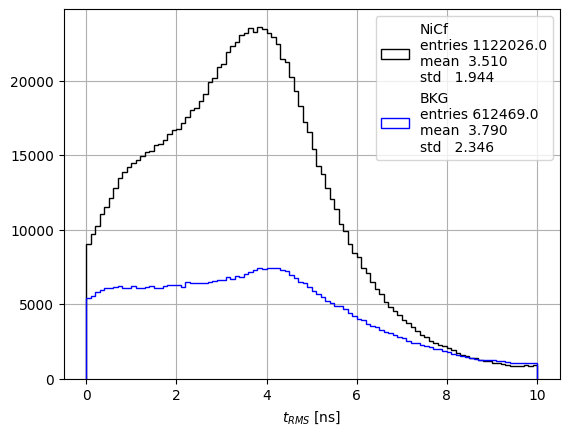

In [14]:
# --- Factor de escala global (regla de tres) ---
scale_factor = len(nicf_run_corrected_times)/len(bkg__run_corrected_times)

# --- Escalado bin-a-bin del histograma de background ---
counts_bkg_scaled = v_bkg * scale_factor

# --- Incertidumbres (Poisson) antes y después del escalado ---
err_bkg = np.sqrt(v_bkg)           # sigma original (Poisson)
err_bkg_scaled = err_bkg * scale_factor # al multiplicar counts por factor, la sigma escala igual

# --- Dibujar comparación (barras) ---
bin_centers = 0.5 * (bins[:-1] + bins[1:])
width = bins[1] - bins[0]

# Arriba: counts por bin: NICF (puntos) y BKG escalado (barras con error)
v_sig, b_sig, _ = pltext.hist(nicf_rms_50ns, 100, ylog=False, xylabels="$t_{RMS}$ [ns]", label="NiCf");
v_bkg, b_bkg, _ = pltext.hist(bkg__rms_50ns, 100, weights=np.ones_like(bkg__50ns_size) * scale_factor, label=f"BKG");
plt.legend();

### tRMS vs. 

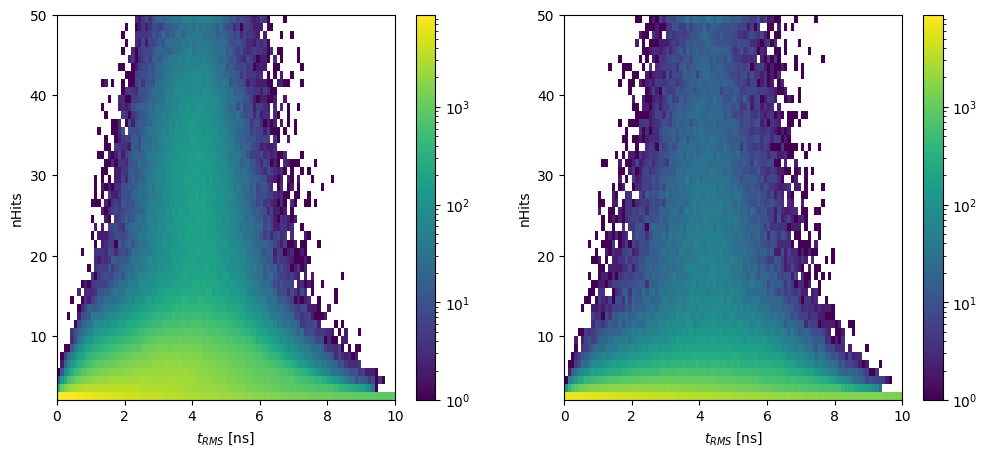

In [15]:
subplot = pltext.canvas(2)

subplot(1)
h1, xedges, yedges, im1 = plt.hist2d(nicf_rms_50ns, nicf_50ns_size, bins=(100, 48), range=((0, 10), (2, 50)), norm="log")

plt.colorbar(im1)

plt.xlabel("$t_{RMS}$ [ns]");
plt.ylabel("nHits");

subplot(2)
h = plt.hist2d(bkg__rms_50ns, bkg__50ns_size, bins=(100, 48), range=((0, 10), (2, 50)), norm="log", vmax=h1.max())

plt.colorbar(h[3])

plt.xlabel("$t_{RMS}$ [ns]");
plt.ylabel("nHits");

### Charge

In [16]:
charge_in_run_bkg = []
for k,v in tqdm(bkg__triggered_signal_hits_index.items(), total=len(bkg__triggered_signal_hits_index.items()), leave=False):
    charge_per_event_bkg = [bkg__noSpill_charge[k][i] for i in bkg__triggered_signal_hits_index.get(k)]
    charge_in_run_bkg.append(charge_per_event_bkg)  

charge_in_run_bkg = ak.Array(charge_in_run_bkg)
sum_charge_in_run_bkg = ak.flatten(ak.sum(charge_in_run_bkg, axis=-1))
mean_charge_in_run_bkg = ak.flatten(ak.mean(charge_in_run_bkg, axis=-1))

 21%|██        | 9763/47109 [00:29<01:36, 388.42it/s]

In [17]:
charge_in_run_nicf = []
for k,v in tqdm(nicf_triggered_signal_hits_index.items(), total=len(nicf_triggered_signal_hits_index.items()), leave=False):
    charge_per_event_nicf = [nicf_noSpill_charge[k][i] for i in nicf_triggered_signal_hits_index.get(k)]
    charge_in_run_nicf.append(charge_per_event_nicf)  

charge_in_run_nicf = ak.Array(charge_in_run_nicf)
sum_charge_in_run_nicf = ak.flatten(ak.sum(charge_in_run_nicf, axis=-1))
mean_charge_in_run_nicf = ak.flatten(ak.mean(charge_in_run_nicf, axis=-1))

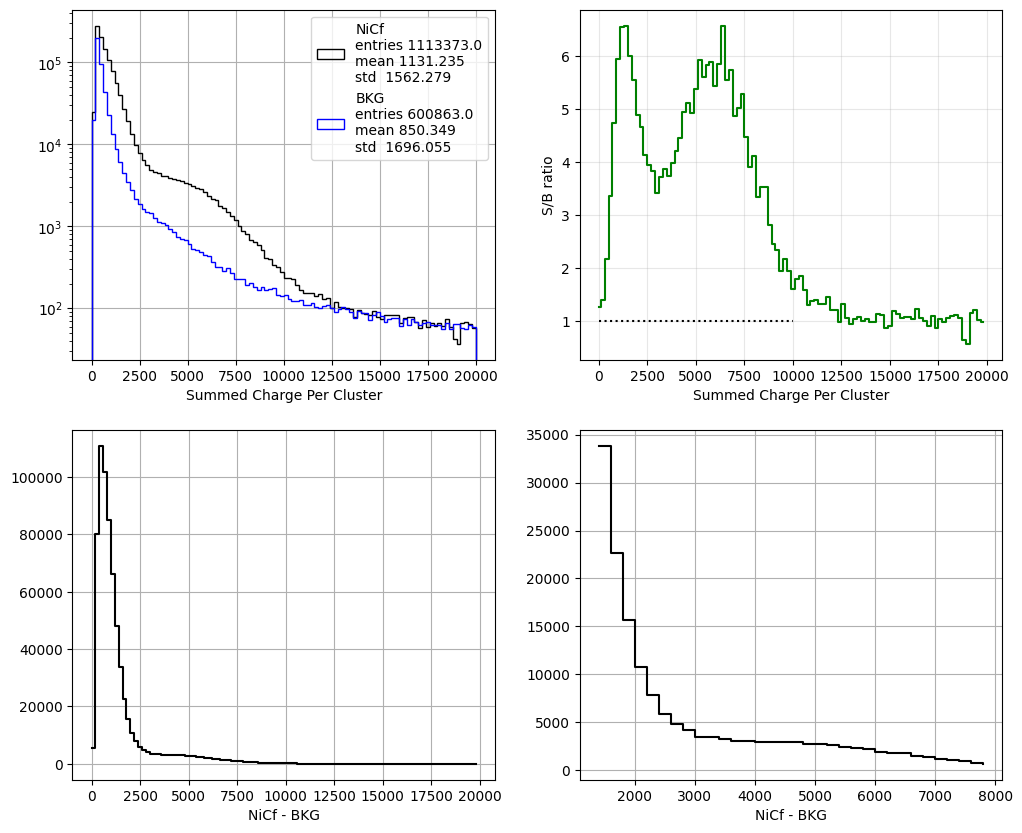

In [18]:
bins = np.arange(2, 139)

# --- Factor de escala global (regla de tres) ---
scale_factor = len(nicf_run_corrected_times)/len(bkg__run_corrected_times)

# --- Escalado bin-a-bin del histograma de background ---
counts_bkg_scaled = v_bkg * scale_factor

# --- Incertidumbres (Poisson) antes y después del escalado ---
err_bkg = np.sqrt(v_bkg)           # sigma original (Poisson)
err_bkg_scaled = err_bkg * scale_factor # al multiplicar counts por factor, la sigma escala igual

# --- Dibujar comparación (barras) ---
bin_centers = 0.5 * (bins[:-1] + bins[1:])
width = bins[1] - bins[0]

# fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios":[3,1]}, sharex=True)

subplot = pltext.canvas(4)

subplot(1)
# Arriba: counts por bin: NICF (puntos) y BKG escalado (barras con error)
v_sig, b_sig, _ = pltext.hist(sum_charge_in_run_nicf, 100, range=(0, 20e3), xylabels="Summed Charge Per Cluster", ylog=True, label="NiCf");
v_bkg, b_bkg, _ = pltext.hist(sum_charge_in_run_bkg,  100, range=(0, 20e3), weights=np.ones_like(sum_charge_in_run_bkg) * scale_factor, label=f"BKG");
# v_bkg, b_bkg = np.histogram(sum_charge_in_run_bkg,  100, range=(5e2, 10e3), weights=np.ones_like(sum_charge_in_run_bkg) * scale_factor);

subplot(2)
ratio = np.divide(v_sig, v_bkg)
plt.step(b_sig[:-1], ratio, where='mid', color='green')
plt.ylabel("S/B ratio")
plt.xlabel("Summed Charge Per Cluster")
plt.grid(alpha=0.3)
plt.hlines(1.0, 0, 10e3, linestyles=":", color="k");

subplot(3)
subs = np.subtract(v_sig, v_bkg)
plt.step(b_sig[:-1], subs, where="post");
plt.xlabel("NiCf - BKG");
plt.grid(True);
# plt.xlim(0, 2500);
# plt.yscale("log");

subplot(4)
subs = np.subtract(v_sig[7:40], v_bkg[7:40])
plt.step(b_sig[7:40], subs, where="post");
plt.xlabel("NiCf - BKG");
plt.grid(True);
# plt.xlim(2500, 7500);
# plt.yscale("log");

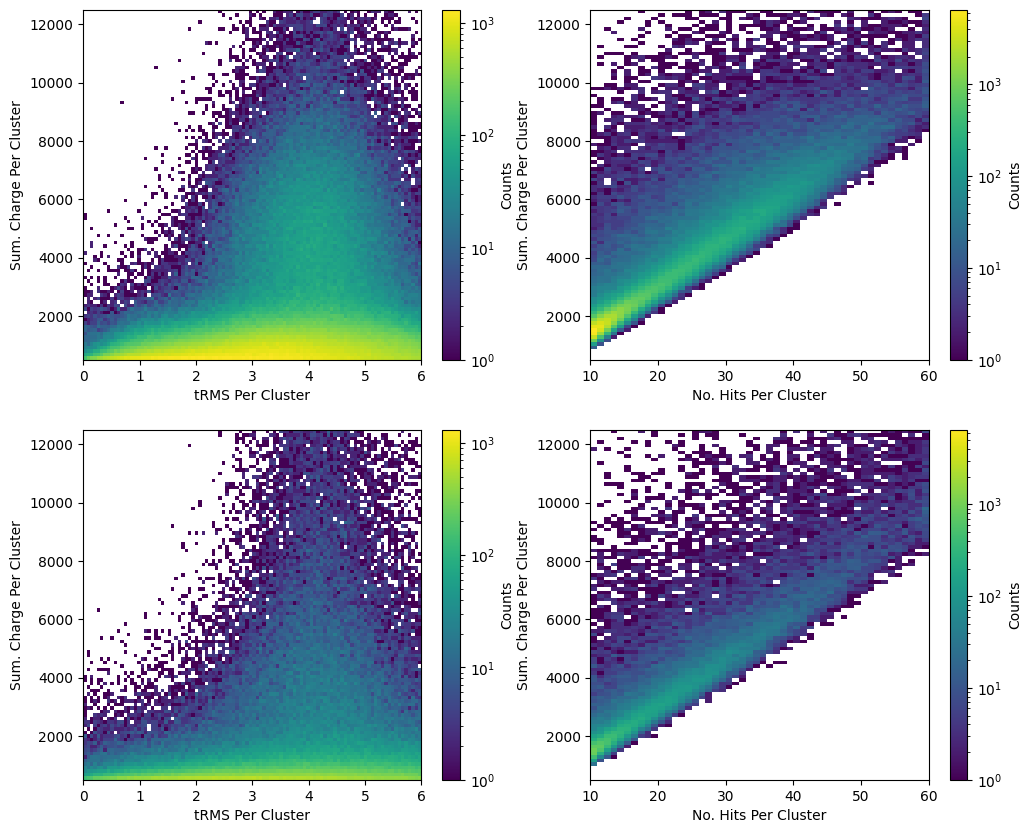

In [19]:
cInfCut = 500  # adc
cSupCut = 12.5e3 # adc

tInfCut = 0 # ns
tSupCut = 6 # ns

hInfCut = 10 # hits
hSupCut = 60 # hits

subplot = pltext.canvas(4)

subplot(1)
h1, xedges, yedges, im1 = plt.hist2d(nicf_rms_50ns, sum_charge_in_run_nicf.to_numpy(), (100, 100), norm="log", range=((tInfCut, tSupCut), (cInfCut, cSupCut)));
plt.colorbar(im1, label="Counts")
plt.xlabel("tRMS Per Cluster");
plt.ylabel("Sum. Charge Per Cluster");

subplot(2)
h2, xedges, yedges, im2 = plt.hist2d(nicf_50ns_size, sum_charge_in_run_nicf.to_numpy(), (50, 100), norm="log", range=((hInfCut, hSupCut), (cInfCut, cSupCut)));
plt.colorbar(im2, label="Counts")
plt.xlabel("No. Hits Per Cluster");
plt.ylabel("Sum. Charge Per Cluster");

subplot(3)
h3, xedges, yedges, im3 = plt.hist2d(bkg__rms_50ns, sum_charge_in_run_bkg.to_numpy(), (100, 100), norm="log", range=((tInfCut, tSupCut), (cInfCut, cSupCut)), vmax=h1.max());
plt.colorbar(im3, label="Counts")
plt.xlabel("tRMS Per Cluster");
plt.ylabel("Sum. Charge Per Cluster");

subplot(4)
h4, xedges, yedges, im4 = plt.hist2d(bkg__50ns_size, sum_charge_in_run_bkg.to_numpy(), (50, 100), norm="log", range=((hInfCut, hSupCut), (cInfCut, cSupCut)), vmax=h2.max());
plt.colorbar(im4, label="Counts")
plt.xlabel("No. Hits Per Cluster");
plt.ylabel("Sum. Charge Per Cluster");

# Compare Simulation And Data

In [20]:
windowTimeGammasFromNi = pd.read_pickle(f"../../mc_analysis/NB/files/windowTimeGammasFromNi.pkl")
windowTrmsGammasFromNi = pd.read_pickle(f"../../mc_analysis/NB/files/windowTrmsGammasFromNi.pkl")
windowTimeGammasFromH  = pd.read_pickle(f"../../mc_analysis/NB/files/windowTimeGammasFromH.pkl")
windowTrmsGammasFromH  = pd.read_pickle(f"../../mc_analysis/NB/files/windowTrmsGammasFromH.pkl")
windowTimeGammas9MeV   = pd.read_pickle(f"../../mc_analysis/NB/files/windowTimeGammas9MeV.pkl")
windowTrmsGammas9MeV   = pd.read_pickle(f"../../mc_analysis/NB/files/windowTrmsGammas9MeV.pkl")
nOfHitsNi              = pd.read_pickle(f"../../mc_analysis/NB/files/nOfHitsNi.pkl")
nOfHitsH               = pd.read_pickle(f"../../mc_analysis/NB/files/nOfHitsH.pkl")
nOfHits9MeV            = pd.read_pickle(f"../../mc_analysis/NB/files/nOfHits9MeV.pkl")

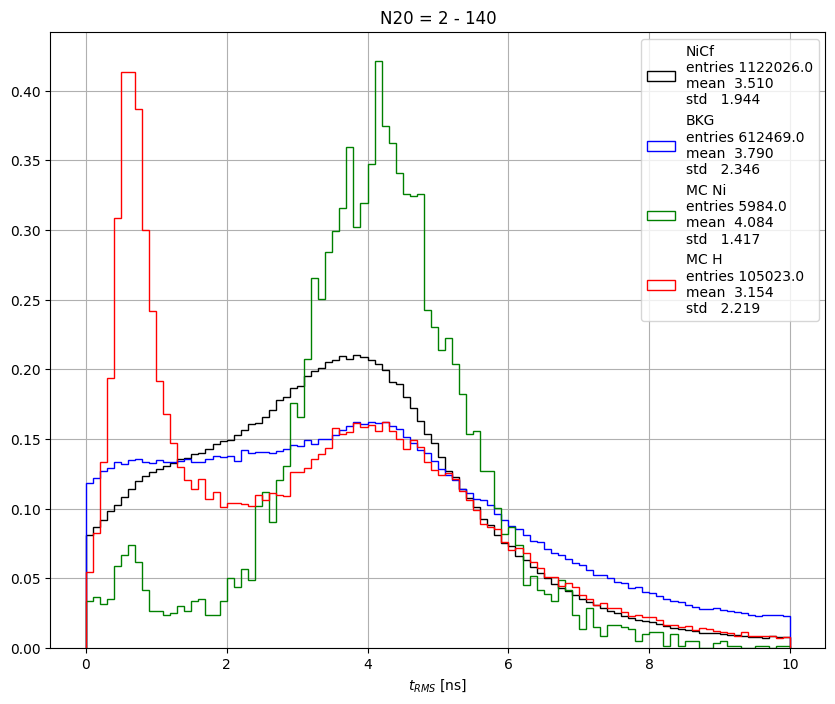

In [21]:
# Plots
# subplot = pltext.canvas(3)

# subplot(1)
plt.figure(figsize=(10, 8))
# v_sig, b_sig, _ = pltext.hist(nicf_50ns_size, 136, range=(thresh_inf, 138), ylog=True, density=True, xylabels=f"{sliding_window} ns Window No. Hits", label="NiCf");
# v_bkg, b_bkg, _ = pltext.hist(bkg__50ns_size, 136, range=(thresh_inf, 138), ylog=True, density=True, xylabels=f"{sliding_window} ns Window No. Hits", label="BKG");
# pltext.hist(                  nOfHitsNi,      136, range=(thresh_inf, 138), ylog=True, density=True, xylabels=f"{sliding_window} ns Window No. Hits", label="MC Ni");
# pltext.hist(                  nOfHitsH,       136, range=(thresh_inf, 138), ylog=True, density=True, xylabels=f"{sliding_window} ns Window No. Hits", label="MC H");
# plt.title(f"N{sliding_window} = {thresh_inf} - {thresh_sup}");

# subplot(2)
pltext.hist([i for i in nicf_rms_50ns if i!= 0], 100, range=(0, 10), density=True, xylabels="$t_{RMS}$ [ns]", label="NiCf");
pltext.hist([i for i in bkg__rms_50ns if i!= 0], 100, range=(0, 10), density=True, xylabels="$t_{RMS}$ [ns]", label="BKG");
pltext.hist([i for i in windowTrmsGammasFromNi if i!=0], 100, range=(0, 10), density=True, xylabels="$t_{RMS}$ [ns]", label="MC Ni");
pltext.hist([i for i in windowTrmsGammasFromH if i!=0], 100, range=(0, 10), density=True, xylabels="$t_{RMS}$ [ns]", label="MC H");
# plt.vlines(2, 0, 1e4);
plt.title(f"N{sliding_window} = {thresh_inf} - {thresh_sup}");

# subplot(3)
# bin_centers = 0.5 * (b_sig[1:] + b_sig[:-1])
# ratio = np.divide(v_sig, v_bkg, out=np.zeros_like(v_sig), where=v_bkg>0)
# plt.step(bin_centers, ratio, where='mid', color='green')
# plt.ylabel("S/B ratio")
# plt.xlabel("tRMS")
# plt.grid(alpha=0.3)
# plt.xlim(thresh_inf, 140)
# plt.hlines(1.0, 0, 120, linestyles=":", color="k");

# Select Filtered Data

### Create The Data Selection

In [22]:
count = 0
signal_clusters = []
signal_indices  = []
len_signal_clusters = []

trms_cut_inf   = 0
trms_cut_sup   = 6.0
noHits_cut_inf = 10
noHits_cut_sup = 60

for k,v in tqdm(nicf_triggered_signal_hit_times.items(), total=len(nicf_triggered_signal_hit_times.items()), leave=True):
        count += 1
        event_signal_clusters = []
        event_signal_indices  = []
        event_len_signal_clusters = []
        for i,j in zip(nicf_triggered_signal_hit_times.get(k), nicf_triggered_signal_hits_index.get(k)):
            # In order to produce unfiltered N20 candidates data tuples next line should be commented out.
            if np.std(i, ddof=0) > trms_cut_inf and np.std(i, ddof=0) < trms_cut_sup and noHits_cut_inf < len(i) <= noHits_cut_sup:
                event_signal_indices.append(j)
                event_signal_clusters.append(i)
                event_len_signal_clusters.append(len(i))

        signal_clusters.append(event_signal_clusters)
        signal_indices.append(event_signal_indices)
        len_signal_clusters.append(event_len_signal_clusters)

        # if count > 3:
        #     break

signal_indices = ak.Array([ak.ravel(signal_indices[i]) for i in range(len(signal_indices))])
len_signal_clusters = ak.Array(len_signal_clusters)

100%|██████████| 35256/35256 [00:51<00:00, 679.23it/s]


In [23]:
nicf_times_df            = nicf_noSpill_times       [signal_indices]
nicf_charge_df           = nicf_run_hit_charges     [signal_indices]
nicf_hit_card_ids_df     = nicf_run_hit_card_ids    [signal_indices]
nicf_hit_channel_ids_df  = nicf_run_hit_channel_ids [signal_indices]
nicf_hit_slot_ids_df     = nicf_run_hit_slot_ids    [signal_indices]
nicf_hit_position_ids_df = nicf_run_hit_position_ids[signal_indices]

In [24]:
flat_nicf_times_df            = ak.flatten(nicf_times_df           , axis=1)
flat_nicf_charge_df           = ak.flatten(nicf_charge_df          , axis=1)
flat_nicf_hit_card_ids_df     = ak.flatten(nicf_hit_card_ids_df    , axis=1)
flat_nicf_hit_channel_ids_df  = ak.flatten(nicf_hit_channel_ids_df , axis=1)
flat_nicf_hit_slot_ids_df     = ak.flatten(nicf_hit_slot_ids_df    , axis=1)
flat_nicf_hit_position_ids_df = ak.flatten(nicf_hit_position_ids_df, axis=1)

flat_counts   = ak.flatten(len_signal_clusters)

unf_nicf_times_df            = ak.unflatten(flat_nicf_times_df,            flat_counts)
unf_nicf_charge_df           = ak.unflatten(flat_nicf_charge_df,           flat_counts)
unf_nicf_hit_card_ids_df     = ak.unflatten(flat_nicf_hit_card_ids_df,     flat_counts)
unf_nicf_hit_channel_ids_df  = ak.unflatten(flat_nicf_hit_channel_ids_df,  flat_counts)
unf_nicf_hit_slot_ids_df     = ak.unflatten(flat_nicf_hit_slot_ids_df,     flat_counts)
unf_nicf_hit_position_ids_df = ak.unflatten(flat_nicf_hit_position_ids_df, flat_counts)

In [25]:
events           = np.arange(0, len(unf_nicf_charge_df))
n_hits_per_event = ak.num(unf_nicf_charge_df)
events           = np.repeat(events, n_hits_per_event)

### Create the array and save the data

In [26]:
events               = np.repeat(np.arange(len(unf_nicf_charge_df)), ak.num(unf_nicf_charge_df))
times                = ak.to_numpy(ak.ravel(unf_nicf_times_df))
charges              = ak.to_numpy(ak.ravel(unf_nicf_charge_df))
card_ids             = ak.to_numpy(ak.ravel(unf_nicf_hit_card_ids_df))
slot_ids             = ak.to_numpy(ak.ravel(unf_nicf_hit_slot_ids_df))
channel_ids          = ak.to_numpy(ak.ravel(unf_nicf_hit_channel_ids_df))
position_ids         = ak.to_numpy(ak.ravel(unf_nicf_hit_position_ids_df))

data = np.column_stack([
    events,
    times,
    charges,
    card_ids,
    slot_ids,
    channel_ids,
    position_ids
])

In [27]:
# 1. Compute the summed charge per event_id
event_ids, sums = np.unique(events, return_inverse=False, return_counts=False), np.zeros(len(np.unique(events)))
sums = np.bincount(events.astype(int), weights=charges)

# 2. Create the mask (per event)
mask = (sums > 500) & (sums < 12500)
selected_event_ids = np.where(mask)[0]

# 3. Create the whole mask
hit_mask = np.isin(events, selected_event_ids)

# 4. Apply Mask
filtered_data = data[hit_mask]

print(f"Total hits: {len(data)}, selected hits: {len(filtered_data)}")

Total hits: 3219824, selected hits: 2594898


In [36]:
# Guardamos directamente en CSV
np.savetxt(
    "test.csv",
    filtered_data,
    delimiter=",",
    header="event_id,hit_pmt_calibrated_times,hit_pmt_charges,hit_mpmt_card_ids,hit_mpmt_slot_ids,hit_pmt_channel_ids,hit_pmt_position_ids",
    comments="",
    fmt="%.6f"  # o "%d" para enteros si quieres tipos explícitos
)

### Explore Filtered Data

In [29]:
hit_pmts = ak.flatten(nicf_hit_slot_ids_df*19 + nicf_hit_position_ids_df)

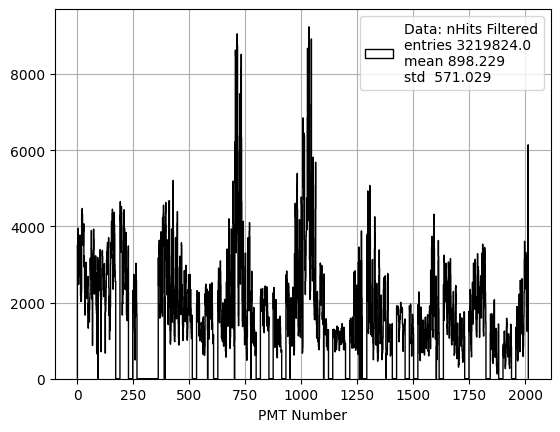

In [30]:
pltext.hist(hit_pmts, 2013, xylabels="PMT Number", label="Data: nHits Filtered");

In [31]:
slot_ids_charge_filtered = filtered_data[:,4]
posi_ids_charge_filtered = filtered_data[:,6]

hit_pmts_charge_filtered = slot_ids_charge_filtered*19 + posi_ids_charge_filtered

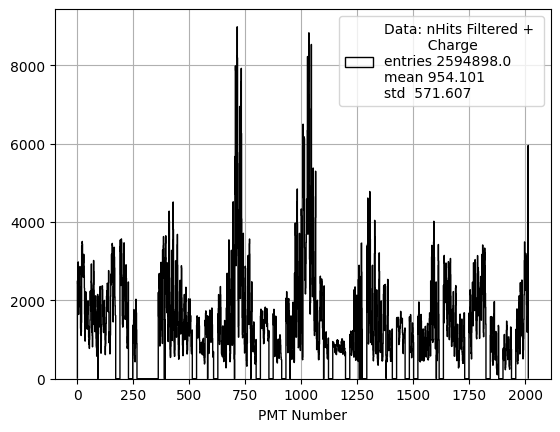

In [32]:
pltext.hist(hit_pmts_charge_filtered, 2013, xylabels="PMT Number", label="Data: nHits Filtered + \n          Charge");